# Supervised Fine-Tuning (SFT) with Parameter Efficient Fine Tuning(PEFT LoRA) of Amazon Nova using Amazon SageMaker Training Job

You can customize Amazon Nova models through base recipes using Amazon SageMaker training jobs. These recipes support Supervised Fine-Tuning (SFT) and Direct Preference Optimization (DPO), with both Full-Rank and Low-Rank Adaptation (LoRA) options.

The end-to-end customization workflow involves stages like model training, model evaluation, and deployment for inference. This model customization approach on SageMaker AI provides greater flexibility and control to fine-tune its supported Amazon Nova models, optimize hyperparameters with precision, and implement techniques including LoRA Parameter-Efficient Fine-Tuning (PEFT), Full-Rank Supervised Fine-Tuning, and Direct Preference Optimization (DPO).

This notebook demonstrates Supervised Fine-Tuning (SFT) with Parameter-Efficient Fine-Tuning (PEFT) of Amazon Nova using Amazon SageMaker Training Job. SFT is a technique that allows fine-tuning language models on specific tasks using labeled examples, while PEFT enables efficient fine-tuning by updating only a small subset of the model's parameters.


> _**Note:** This notebook demonstrates fine-tuning using Nova Lite, but the same techniques can be applied to Nova Pro or Nova Micro models with appropriate adjustments to the configuration._


## Installing Dependencies

The first cell installs the required Python packages for this notebook. For more details on other pre-requisites needed check out [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/nova-model-general-prerequisites.html)

In [83]:
!pip install -r ./requirements.txt --upgrade

In [84]:
!pip install "sagemaker==2.254.1"

***

## Step 0: Prerequisites

This section sets up the necessary AWS credentials and SageMaker session to run the notebook. You'll need proper IAM permissions to use SageMaker.


If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.

The code initializes a SageMaker session, sets up the IAM role, and configures the S3 bucket for storing training data and model artifacts.


In [85]:
import sagemaker
import boto3

sess = sagemaker.Session()
sagemaker_session_bucket = None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
bucket_name = sess.default_bucket()
default_prefix = sess.default_bucket_prefix

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::905418197933:role/service-role/AmazonSageMaker-ExecutionRole-20250423T112956
sagemaker bucket: sagemaker-us-east-1-905418197933
sagemaker session region: us-east-1


### Low-rank adapter fine tuning


The most effective and cost-efficient method to enhance the base model performance is through the utilization of Low Rank Adapter (LoRA) fine-tuning. The underlying principle of LoRA is that only a small number of additional weights requires updating to adapt it to new tasks or domains. LoRA efficiently fine-tunes large language models by introducing low-rank trainable weight matrices into specific model layers, reducing the number of trainable parameters while maintaining model quality. A LoRA adapter augments the base foundation model by incorporating lightweight adapter layers that modify the model’s weights during inference, while keeping the original model parameters frozen. This approach is also considered one of the most cost-effective fine-tuning techniques. For more information, see Fine-tune models with adapter inference components

In what cases is Low-rank Adapter Fine tuning recommended?

* Developers are recommended to generally start with Low-rank Adapter Fine tuning due to its fast training procedure.
* It is recommended to use Low-rank Adapter (LoRA) fine-tuning in cases where the base model performance is already satisfactory, and the goal is to enhance the model's capabilities across multiple related tasks, such as text summarization and language translation. LoRA's regularization properties help prevent over-fitting and mitigate the "forgetting" of the source domain, ensuring the model remains versatile and adaptable to various applications.
* Consider using LoRA for instruction fine-tuning (IFT) scenarios with relatively small datasets. LoRA performs better with smaller, task-specific datasets than broader larger datasets.
* It is recommended to leverage Low-rank Adapter (LoRA) fine-tuning on Amazon SageMaker AI when the developer has a larger labeled dataset that exceeds the Bedrock Customization Data Limits.
* Additionally, LoRA on SageMaker AI is recommended when the developer has already achieved promising results through Bedrock Customization, and seeks to further optimize hyper-parameters.

![imgs/lora_based_arch.png](imgs/lora_based_arch.png)


***

## Step 1: Prepare the dataset

In this example, we are going to load [glaiveai/glaive-function-calling-v2](https://huggingface.co/datasets/glaiveai/glaive-function-calling-v2) dataset, an open-source dataset and model suite focused on enabling and improving function calling capabilities for large language models (LLMs)

### Step 1.1: Data Loading

This code loads the first 10,000 examples from the glaive-function-calling-v2 dataset from Hugging Face.


In [86]:
from datasets import load_dataset

# Load the 'ibm-research/finqa' dataset. 
# It is common practice to specify a split (like "train") for large datasets.
# We'll use the same slicing structure [:] as the original example if you want to limit the size,
# but usually, you'd specify a standard split (like "train") first.

# Option 1: Load the entire 'train' split
dataset = load_dataset("ibm-research/finqa", split="train")

# Option 2 (If you want to load only the first 100 examples, matching the original format):
# dataset = load_dataset("ibm-research/finqa", split="train[:100]")
dataset

Dataset({
    features: ['id', 'pre_text', 'post_text', 'table', 'question', 'answer', 'final_result', 'program_re', 'gold_inds'],
    num_rows: 6251
})

Converting the dataset to a pandas DataFrame makes it easier to work with and manipulate.


In [87]:
from typing import Dict, Any, List 

def finqa_to_instruction_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """
    Converts a single FinQA example (context, table, question, program)
    into a standardized instruction format (list of messages).
    """

    # 1. Format the Table data for inclusion in the prompt
    # The 'table' feature is a dictionary of headers and values.
    try:
        table_str = "\n".join(
            [f"| {h} | {v} |" for h, v in example['table'].items()]
        )
    except Exception:
        # Handle cases where table might be malformed or empty
        table_str = "No structured table data provided."
    
    # 2. Construct the User Prompt
    # We combine the necessary context (pre_text, table, question)
    user_prompt = f"""Given the following financial context and table data:

---
CONTEXT: {example['pre_text']}

TABLE:
{table_str}

---
QUESTION: {example['question']}

Please generate the step-by-step calculation program to answer the question."""

    # 3. Define the Assistant Response
    # The program_re field contains the executable program/steps which the model must output.
    assistant_response = example['program_re']

    # 4. Assemble the Messages List
    messages: List[Dict[str, Any]] = [
        {
            "role": "system",
            "content": "You are a specialized financial analysis AI. Your task is to convert financial questions into accurate executable calculation programs based on provided context and data."
        },
        {
            "role": "user",
            "content": user_prompt
        },
        {
            "role": "assistant",
            "content": assistant_response
        }
    ]

    # The FinQA dataset does not involve function calling, so tools are None.
    return {
        "messages": messages, 
        "tools": None
    }

# --- 3. Apply the Preprocessing ---



In [88]:
# Use .map() to apply the transformation function to every row in the dataset
import json
from typing import Dict, Any, List # <-- FIX: Import necessary types
from datasets import load_dataset, Dataset
processed_dataset: Dataset = dataset.map(finqa_to_instruction_format)

# Review the structure of the first processed entry
print(processed_dataset)
print("\n--- Example Processed Message Structure ---")
print(processed_dataset[0]['messages'])

Dataset({
    features: ['id', 'pre_text', 'post_text', 'table', 'question', 'answer', 'final_result', 'program_re', 'gold_inds', 'messages', 'tools'],
    num_rows: 6251
})

--- Example Processed Message Structure ---
[{'content': 'You are a specialized financial analysis AI. Your task is to convert financial questions into accurate executable calculation programs based on provided context and data.', 'role': 'system'}, {'content': "Given the following financial context and table data:\n\n---\nCONTEXT: ['interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .', 'if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .', 'foreign currency exposure as more fully described in note 2i .', 'in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .', 'dollar-based exposures by enterin

In [89]:
import pandas as pd

df = pd.DataFrame(processed_dataset)

df.head()

,id,pre_text,post_text,table,question,answer,final_result,program_re,gold_inds,messages,tools
0,ADI/2009/page_49.pdf-1,[interest rate to a variable interest rate bas...,[fair value of forward exchange contracts afte...,"[[, october 31 2009, november 1 2008], [fair v...",what is the the interest expense in 2009?,380,380,"divide(100, 100), divide(3.8, #0)","[if libor changes by 100 basis points , our an...",[{'content': 'You are a specialized financial ...,None
1,ABMD/2012/page_75.pdf-1,"[abiomed , inc ., and subsidiaries notes to co...",[the remaining unrecognized compensation expen...,"[[, number of shares ( in thousands ), weighte...","during the 2012 year , did the equity awards i...",,yes,"multiply(607, 18.13), multiply(#0, const_1000)...",[the granted of number of shares ( in thousand...,[{'content': 'You are a specialized financial ...,None
2,AAL/2018/page_13.pdf-2,[the following table shows annual aircraft fue...,"[as of december 31 , 2018 , we did not have an...","[[year, gallons, average priceper gallon, airc...",what was the total operating expenses in 2018 ...,41932,41932,"divide(9896, 23.6%)",[year the 2018 of gallons is 4447 ; the 2018 o...,[{'content': 'You are a specialized financial ...,None
3,INTC/2013/page_71.pdf-4,[the fair value of our grants receivable is de...,"[in the third quarter of 2013 , we sold our sh...","[[( in millions ), dec 282013, dec 292012], [a...",what percentage of total cash and investments ...,53%,53%,"divide(14001, 26302)",[( in millions ) the available-for-sale invest...,[{'content': 'You are a specialized financial ...,None
4,ETR/2008/page_313.pdf-3,"[entergy louisiana , llc management's financia...",[the retail electric price variance is primari...,"[[, amount ( in millions )], [2007 net revenue...",what is the growth rate in net revenue in 2008?,-3.2%,-3.2%,"subtract(959.2, 991.1), divide(#0, 991.1)",[the 2007 net revenue of amount ( in millions ...,[{'content': 'You are a specialized financial ...,None


### Step 1.2: Train/Val/Test Split

The dataset is split into training (72%), validation (18%), and test (10%) sets to properly evaluate the model. 

In [90]:
from sklearn.model_selection import train_test_split

temp, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(temp, test_size=0.2, random_state=42)

print("Number of train elements: ", len(train))
print("Number of test elements: ", len(test))
print("Number of val elements: ", len(val))

Number of train elements:  4500
Number of test elements:  626
Number of val elements:  1125


### Understanding the Nova Format

Let's format the dataset by using the prompt style for Amazon Nova:

```
{
    "system": [{"text": Content of the System prompt}],
    "messages": [
        {
            "role": "user",
            "content": ["text": Content of the user prompt]
        },
        {
            "role": "assistant",
            "content": ["text": Content of the answer]
        },
        ...
    ]
}
```

### Step 1.3: Data Preprocessing 

The notebook defines utility functions to clean the dataset content by removing prefixes and handling special cases:

```python
def clean_prefix(content):
    # Removes prefixes like "USER:", "ASSISTANT:", etc.
    ...

def clean_message_list(message_list):
    # Cleans message lists from None values and converts to proper format
    ...

def clean_numbered_conversation(message_list):
    # Cleans message lists from None values and converts to proper format
    ...
```

In [91]:
import json
import re
from typing import Dict, Any, List
from datasets import load_dataset, Dataset

# --- Provided Cleaning Utility ---

def clean_prefix(content):
    """Remove conversational prefixes from content."""
    prefixes = [ "SYSTEM:", "System:", "USER:", "User:", "ASSISTANT:", "Assistant:", "Bot:", "BOT:", ]
    if isinstance(content, str):
        lines = content.split("\n")
        cleaned_lines = []
        for line in lines:
            cleaned_line = line.strip()
            for prefix in prefixes:
                if cleaned_line.startswith(prefix):
                    cleaned_line = cleaned_line[len(prefix) :].strip()
                    break
            cleaned_lines.append(cleaned_line)
        return "\n".join(cleaned_lines)
    return content

# --- FinQA to Standard Format Processor ---

def finqa_to_instruction_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """Converts a single FinQA example into the standard list-of-messages format."""
    
    # 1. Format the Table
    table_data = example.get('table', [])
    table_str = ""
    if table_data and isinstance(table_data, list) and table_data[0]:
        header = table_data[0]
        rows = table_data[1:]
        table_str += "| " + " | ".join(map(str, header)) + " |\n"
        table_str += "| " + " | ".join(["---"] * len(header)) + " |\n"
        for row in rows:
            table_str += "| " + " | ".join(map(str, row)) + " |\n"
    else:
        table_str = "No structured table data provided."
    
    # 2. Construct the User Prompt
    user_prompt = f"""Given the following financial context and table data:

---
CONTEXT: {example['pre_text']}

TABLE:
{table_str}

---
QUESTION: {example['question']}

Please generate the step-by-step calculation program to answer the question."""

    assistant_response = example['program_re']

    # 3. Assemble Messages List (Standard Format)
    messages: List[Dict[str, Any]] = [
        {"role": "system", "content": "You are a specialized financial analysis AI. Your task is to convert financial questions into accurate executable calculation programs based on provided context and data."},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": assistant_response}
    ]

    # Return only the keys needed for the next step
    return {"messages": messages} 

# --- Nova Format Conversion Function (Final Transformation) ---

def convert_to_nova_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """
    Converts standard message list into the required Nova format structure,
    including the nested content [{"text": ...}].
    """
    standard_messages = example.get("messages", [])
    if not standard_messages:
        return {"system": [], "messages": []}

    nova_system = []
    nova_messages = []

    for i, msg in enumerate(standard_messages):
        role = msg["role"]
        content = msg["content"]
        cleaned_content = clean_prefix(content)
        
        # All content must be wrapped in [{"text": ...}] for Nova format
        nova_content_struct = [{"text": cleaned_content}]
        
        if role == "system" and i == 0:
            # System content goes into the top-level 'system' key
            nova_system = nova_content_struct
        else:
            # User/Assistant content goes into the 'messages' list
            nova_messages.append({
                "role": role,
                "content": nova_content_struct
            })
            
    # Return ONLY the final Nova keys
    return {
        "system": nova_system,
        "messages": nova_messages,
    }


# ==========================================================
# FULL EXECUTION
# ==========================================================

print("1. Loading FinQA dataset...")
dataset = load_dataset("ibm-research/finqa", split="train") 

# Get the list of columns to remove later
initial_columns_to_remove = dataset.column_names

# 2. Apply initial preprocessing (Standard Conversational Format)
# We remove the original FinQA columns, leaving only the new 'messages' list
processed_dataset_standard = dataset.map(
    finqa_to_instruction_format, 
    remove_columns=initial_columns_to_remove
)

# 3. Apply final conversion to Nova Format
# We use batched=False here as we are transforming the internal structure
processed_dataset_nova = processed_dataset_standard.map(
    convert_to_nova_format
)

# 4. Clean up the schema by removing the intermediate 'messages' column
processed_dataset_nova = processed_dataset_nova.remove_columns(["messages"])

# Display the result
print("\n--- Final Processed Dataset (Nova Format) ---")
print(processed_dataset_nova)

print("\n--- Example Nova Format Output (Row 0) ---")
# Use json.dumps to ensure the full nested structure is clearly visible
print(json.dumps(processed_dataset_nova[0], indent=2))

1. Loading FinQA dataset...

--- Final Processed Dataset (Nova Format) ---
Dataset({
    features: ['system'],
    num_rows: 6251
})

--- Example Nova Format Output (Row 0) ---
{
  "system": [
    {
      "text": "You are a specialized financial analysis AI. Your task is to convert financial questions into accurate executable calculation programs based on provided context and data."
    }
  ]
}


These functions transform the dataset into the format required by Nova models, handling tool calls and formatting:

```python

def transform_tool_format(tool):
    # Transforms tool format to Nova's expected format
    ...

def prepare_dataset(sample):
    # Prepares dataset in the required format for Nova models
    ...

def prepare_dataset_test(sample):
    # Formats validation dataset for evaluation
    ...
```


In [92]:
import json
import re
from typing import Dict, Any, List
from datasets import load_dataset, DatasetDict, Dataset
from random import randint

# --- Utility Functions (Provided in previous steps) ---

def clean_prefix(content):
    """Remove conversational prefixes from content."""
    prefixes = [ "SYSTEM:", "System:", "USER:", "User:", "ASSISTANT:", "Assistant:", "Bot:", "BOT:", ]
    if isinstance(content, str):
        lines = content.split("\n")
        cleaned_lines = []
        for line in lines:
            cleaned_line = line.strip()
            for prefix in prefixes:
                if cleaned_line.startswith(prefix):
                    cleaned_line = cleaned_line[len(prefix) :].strip()
                    break
            cleaned_lines.append(cleaned_line)
        return "\n".join(cleaned_lines)
    return content

# Placeholder for clean_message_list (used for final cleanup step, as per your request)
def clean_message_list(message_list):
    """Applies clean_prefix to content text within the Nova format structure."""
    if not isinstance(message_list, list):
        return message_list
    
    cleaned = []
    for item in message_list:
        if item.get("content"):
            new_content = []
            for content_item in item["content"]:
                if isinstance(content_item, dict) and "text" in content_item:
                    # Re-apply cleaning here if necessary
                    content_item["text"] = clean_prefix(content_item["text"])
                    new_content.append(content_item)
            item["content"] = new_content
            cleaned.append(item)
    return cleaned

# --- FinQA Data Processing Functions ---

def finqa_to_standard_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """Converts a FinQA example into the intermediate standard message list format."""
    
    # 1. Format Table for prompt
    table_data = example.get('table', [])
    table_str = ""
    # ... (Table formatting logic) ...
    if table_data and isinstance(table_data, list) and table_data[0]:
        header = table_data[0]
        rows = table_data[1:]
        table_str += "| " + " | ".join(map(str, header)) + " |\n"
        table_str += "| " + " | ".join(["---"] * len(header)) + " |\n"
        for row in rows:
            table_str += "| " + " | ".join(map(str, row)) + " |\n"
    else:
        table_str = "No structured table data provided."
    
    user_prompt = f"""Given the following financial context and table data:

---
CONTEXT: {example['pre_text']}

TABLE:
{table_str}

---
QUESTION: {example['question']}

Please generate the step-by-step calculation program to answer the question."""

    assistant_response = example['program_re']

    messages: List[Dict[str, Any]] = [
        {"role": "system", "content": "You are a specialized financial analysis AI. Your task is to convert financial questions into accurate executable calculation programs based on provided context and data."},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": assistant_response}
    ]
    return {"messages": messages}

def convert_to_nova_format(example: Dict[str, Any]) -> Dict[str, Any]:
    """Converts the standard message list into the Nova format structure."""
    standard_messages = example.get("messages", [])
    if not standard_messages:
        return {"system": [], "messages": []}

    nova_system = []
    nova_messages = []

    for i, msg in enumerate(standard_messages):
        role = msg["role"]
        content = msg["content"]
        cleaned_content = clean_prefix(content)
        
        # Required Nova structure: content is [{"text": ...}]
        nova_content_struct = [{"text": cleaned_content}]
        
        if role == "system" and i == 0:
            nova_system = nova_content_struct
        else:
            nova_messages.append({"role": role, "content": nova_content_struct})
            
    # Return the new keys
    return {"system": nova_system, "messages": nova_messages}


# ==========================================================
# EXECUTION
# ==========================================================

print("1. Loading FinQA DatasetDict (all splits)...")
dataset_dict = load_dataset("ibm-research/finqa")

final_dataset_dict = DatasetDict()

# Loop through each split (train, validation, test)
for split_name in dataset_dict.keys():
    print(f"\nProcessing split: {split_name}...")
    
    current_dataset = dataset_dict[split_name]
    initial_features = list(current_dataset.features.keys())
    
    # --- Step 1: Convert FinQA structure to standard message list ---
    processed_std = current_dataset.map(
        finqa_to_standard_format, 
        remove_columns=initial_features
    )
    
    # --- Step 2: Convert standard list to Nova nested format ---
    processed_nova = processed_std.map(
        convert_to_nova_format
    )
    
    # --- Step 3: Apply cleanup and finalize structure (as requested by your code sample) ---
    
    # Convert to pandas to apply column-wise function (clean_message_list)
    processed_df = processed_nova.to_pandas()
    
    # Apply the cleaning function to the 'messages' column
    # Note: 'system' is separate in Nova format, so clean_message_list only applies to 'messages'.
    processed_df["messages"] = processed_df["messages"].apply(clean_message_list)
    
    # Convert back to Dataset and remove the temporary intermediate 'messages' column
    final_dataset = Dataset.from_pandas(processed_df)
    
    # Assign the final processed split to the DatasetDict
    final_dataset_dict[split_name] = final_dataset

    # Print example for verification
    if not final_dataset.num_rows == 0:
        rand_index = randint(0, final_dataset.num_rows - 1)
        print(f"\nExample from {split_name} split (Row {rand_index}):")
        print(json.dumps(final_dataset[rand_index], indent=2))


print("\n--- FINAL RESULT ---")
print(final_dataset_dict)

1. Loading FinQA DatasetDict (all splits)...

Processing split: train...

Example from train split (Row 3039):
{
  "messages": [
    {
      "content": [
        {
          "text": "Given the following financial context and table data:\n\n---\nCONTEXT: ['the goldman sachs group , inc .', 'and subsidiaries notes to consolidated financial statements commercial lending .', 'the firm 2019s commercial lending commitments are extended to investment-grade and non- investment-grade corporate borrowers .', 'commitments to investment-grade corporate borrowers are principally used for operating liquidity and general corporate purposes .', 'the firm also extends lending commitments in connection with contingent acquisition financing and other types of corporate lending as well as commercial real estate financing .', 'commitments that are extended for contingent acquisition financing are often intended to be short-term in nature , as borrowers often seek to replace them with other funding sources 

### Step 1.4: Data Preperation in Converse Format for Train and Validation Datasets

In [93]:
from datasets import Dataset, DatasetDict
from random import randint

# 1. Define the datasets using the correct keys from final_dataset_dict
test_dataset = final_dataset_dict["test"]
val_dataset = final_dataset_dict["validation"]
train_dataset=final_dataset_dict["train"]
rand_index = randint(0, len(test_dataset) - 1)
print(f"Sampling a random example from test_dataset (Index {rand_index}):")
print(test_dataset[rand_index])


Sampling a random example from test_dataset (Index 186):
{'messages': [{'content': [{'text': "Given the following financial context and table data:\n\n---\nCONTEXT: ['share-based compensation cost is recorded net of estimated forfeitures on a straight-line basis for awards with service conditions only , and on a graded-vesting basis for awards with service , performance and market conditions .', 'the company 2019s estimated forfeiture rate is based on an evaluation of historical , actual and trended forfeiture data .', 'for fiscal 2014 , 2013 , and 2012 , the company recorded share-based compensation cost of $ 172 million , $ 179 million and $ 147 million , respectively , in personnel on its consolidated statements of operations .', 'the amount of capitalized share-based compensation cost was immaterial during fiscal 2014 , 2013 and 2012 .', 'options options issued under the eip expire 10 years from the date of grant and vest ratably over 3 years from the date of grant , subject to ear

### Step 1.5: Data Preperation on test data for Offline Evaluation post fine tuning

Let's format the test dataset in the format:

Required Fields:

* query: String containing the question or instruction that needs an answer
* response: String containing the expected model output

Optional Fields:

* system: String containing the system prompt that sets the behavior, role, or personality of the AI model before it processes the query

Example Entry
```

{
   "system":"You are a english major with top marks in class who likes to give minimal word responses: ",
   "query":"What is the symbol that ends the sentence as a question",
   "response":"?"
}
{
   "system":"You are a pattern analysis specialist that provides succinct answers: ",
   "query":"What is the next number in this series? 1, 2, 4, 8, 16, ?",
   "response":"32"
}
{
   "system":"You have great attention to detail that follows instructions accurately: ",
   "query":"Repeat only the last two words of the following: I ate a hamburger today and it was kind of dry",
   "response":"of dry"
}
```

In [94]:

rand_index = randint(0, len(test_dataset) - 1)
print(f"Sampling a random example from test_dataset (Index {rand_index}):")
print(test_dataset[rand_index])


Sampling a random example from test_dataset (Index 985):
{'messages': [{'content': [{'text': "Given the following financial context and table data:\n\n---\nCONTEXT: ['the contracts were valued as of april 1 , 2002 , and an asset and a corresponding gain of $ 127 million , net of income taxes , was recorded as a cumulative effect of a change in accounting principle in the second quarter of 2002 .', 'the majority of the gain recorded relates to the warrior run contract , as the asset value of the deepwater contract on april 1 , 2002 , was less than $ 1 million .', 'the warrior run contract qualifies and was designated as a cash flow hedge as defined by sfas no .', '133 and hedge accounting is applied for this contract subsequent to april 1 , 2002 .', 'the contract valuations were performed using current forward electricity and gas price quotes and current market data for other contract variables .', 'the forward curves used to value the contracts include certain assumptions , including p

### Step 1.6: Upload all 3 curated datasets (train, test, val) to Amazon S3

The notebook applies the functions to transform the datasets into the required formats


The processed datasets are saved locally and then uploaded to Amazon S3 for use in SageMaker training:



In [95]:
import boto3
import shutil

In [96]:
s3_client = boto3.client('s3')

# save train_dataset to s3 using our SageMaker session
if default_prefix:
    input_path = f"{default_prefix}/datasets/nova-sft-peft"
else:
    input_path = f"datasets/nova-sft-peft"

train_dataset_s3_path = f"s3://{bucket_name}/{input_path}/train/dataset.jsonl"
val_dataset_s3_path = f"s3://{bucket_name}/{input_path}/val/dataset.jsonl"
test_dataset_s3_path = f"s3://{bucket_name}/{input_path}/test/gen_qa.jsonl"

In [97]:
import os
import shutil
import boto3
# Assuming sagemaker, bucket_name, default_prefix, input_path, 
# train_dataset_s3_path, val_dataset_s3_path, and test_dataset_s3_path are defined 
# based on the prior steps.

# --- Define local variables for file paths ---
TRAIN_LOCAL_PATH = "./data/train/dataset.jsonl"
VAL_LOCAL_PATH = "./data/val/dataset.jsonl"
TEST_LOCAL_PATH = "./data/test/gen_qa.jsonl"


# 1. Save datasets to local files
print("1. Creating local directories and saving datasets...")
os.makedirs("./data/train", exist_ok=True)
os.makedirs("./data/val", exist_ok=True)
os.makedirs("./data/test", exist_ok=True) # Ensure 'test' directory is also created

# Save the splits from the final_dataset_dict
print(f"Saving train split to {TRAIN_LOCAL_PATH}")
final_dataset_dict["train"].to_json(TRAIN_LOCAL_PATH, orient="records", lines=True)

# Note: The FinQA validation split is stored under the key "validation"
print(f"Saving validation split to {VAL_LOCAL_PATH}")
final_dataset_dict["validation"].to_json(VAL_LOCAL_PATH, orient="records", lines=True)

print(f"Saving test split to {TEST_LOCAL_PATH}")
# Note: Retaining the user's original call signature for test, 
# but generally, 'lines=True' is recommended for .jsonl files.
final_dataset_dict["test"].to_json(TEST_LOCAL_PATH)


# 2. Upload local files to S3
print("\n2. Uploading datasets to S3 using s3_client...")

s3_client.upload_file(
    TRAIN_LOCAL_PATH, bucket_name, f"{input_path}/train/dataset.jsonl"
)

s3_client.upload_file(
    VAL_LOCAL_PATH, bucket_name, f"{input_path}/val/dataset.jsonl"
)

s3_client.upload_file(
    TEST_LOCAL_PATH, bucket_name, f"{input_path}/test/gen_qa.jsonl"
)


# 3. Cleanup local files
print("\n3. Cleaning up local data directory...")
shutil.rmtree("./data")


# 4. Print confirmation
print("\nDatasets uploaded successfully:")
print(f"Training data uploaded to: {train_dataset_s3_path}")
print(f"Validation data uploaded to: {val_dataset_s3_path}")
print(f"Test data uploaded to: {test_dataset_s3_path}")

1. Creating local directories and saving datasets...
Saving train split to ./data/train/dataset.jsonl


Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Saving validation split to ./data/val/dataset.jsonl


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Saving test split to ./data/test/gen_qa.jsonl


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]


2. Uploading datasets to S3 using s3_client...

3. Cleaning up local data directory...

Datasets uploaded successfully:
Training data uploaded to: s3://sagemaker-us-east-1-905418197933/datasets/nova-sft-peft/train/dataset.jsonl
Validation data uploaded to: s3://sagemaker-us-east-1-905418197933/datasets/nova-sft-peft/val/dataset.jsonl
Test data uploaded to: s3://sagemaker-us-east-1-905418197933/datasets/nova-sft-peft/test/gen_qa.jsonl


***

## Step 2: Model fine-tuning

We now define the PyTorch estimator to run the supervised fine-tuning on a tool-calling dataset for our Amazon Nova model

This section sets up and runs the fine-tuning job using SageMaker. It uses Supervised Fine-Tuning (SFT) with Parameter-Efficient Fine-Tuning (PEFT) to efficiently train the model.


#### Instance Type and Count

P5 instances are optimized for deep learning workloads, providing high-performance GPUs.


In [98]:
instance_type = "ml.p5.48xlarge"
instance_count = 4

instance_type

'ml.p5.48xlarge'

#### Image URI

This specifies the pre-built container for SFT fine-tuning, which is different from the DPO container.


In [100]:
image_uri = f"708977205387.dkr.ecr.{sess.boto_region_name}.amazonaws.com/nova-fine-tune-repo:SM-TJ-SFT-V2-latest"

image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-fine-tune-repo:SM-TJ-SFT-V2-latest'

#### Configuring the Model and Recipe

This specifies which model to fine-tune and the recipe to use. The recipe includes "lora" indicating parameter-efficient fine-tuning, and "sft" indicating supervised fine-tuning.


In [101]:
model_id = "nova-lite-2/prod"
recipe="fine-tuning/nova/nova_2_0/nova_lite/SFT/nova_lite_2_0_p5_gpu_lora_sft"

In [102]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"train-{model_id.split('/')[0].replace('.', '-')}-peft-sft"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"

recipe_overrides = {
    "run": {
        "replicas": instance_count,  # Required
    },
}

estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    recipe_overrides=recipe_overrides,
    max_run=432000,
    sagemaker_session=sess,
    image_uri=image_uri
)

INFO:sagemaker:Remote debugging, profiler and debugger hooks are disabled for Nova recipes.


#### Configuring the Data Channels

Configure the Data Channels

In [103]:
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    s3_data=train_dataset_s3_path,
    distribution="FullyReplicated",
    s3_data_type="Converse",
)

val_input = TrainingInput(
    s3_data=val_dataset_s3_path,
    distribution="FullyReplicated",
    s3_data_type="Converse",
)

### Starting the Training Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [104]:
# starting the train job with our uploaded datasets as input
estimator.fit(inputs={"train": train_input, "validation": val_input}, wait=False)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: train-nova-lite-2-peft-sft-2025-11-26-19-15-15-210


In [105]:
training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

Training Job Name:  train-nova-lite-2-peft-sft-2025-11-26-19-15-15-210


In [106]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, training_job_name, "us-east-1")))



---
## _Wait Until the ^^ Training Job ^^ Completes Above!( 20-40 mins)_
---

### Reading the Output Content after training job completion

In [38]:
model_s3_uri = estimator.model_data

output_s3_uri = "/".join(model_s3_uri.split("/")[:-1])+"/output.tar.gz"

### Downloading and Extracting the Artifacts

In [39]:
!mkdir -p ./tmp/train_output/

In [40]:
!aws s3 cp $output_s3_uri ./tmp/train_output/output.tar.gz

download: s3://sagemaker-us-east-1-905418197933/train-nova-lite-2-peft-sft/train-nova-lite-2-peft-sft-2025-11-21-17-09-11-198/output/output.tar.gz to tmp/train_output/output.tar.gz


In [41]:
!tar -xvzf ./tmp/train_output/output.tar.gz -C ./tmp/train_output/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
manifest.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
step_wise_training_metrics.csv


In [42]:
escrow_model_uri = json.load(open('./tmp/train_output/manifest.json'))['checkpoint_s3_bucket']

In [43]:
escrow_model_uri

's3://customer-escrow-905418197933-smtj-4a214be3/train-nova-lite-2-peft-sft-2025-11-21-17-09-11-198/step_100'

### Plotting the Train/Loss Curve 

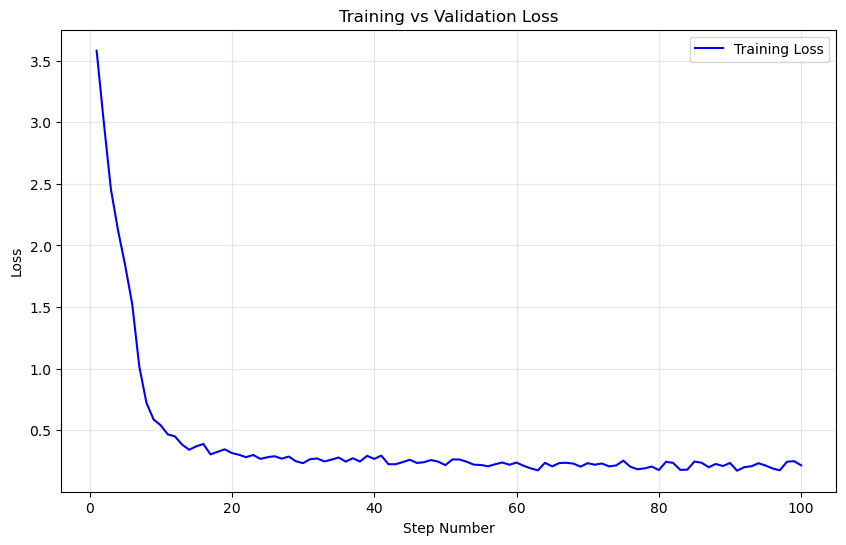

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
train_df = pd.read_csv('./tmp/train_output/step_wise_training_metrics.csv')
# val_df = pd.read_csv('./tmp/train_output/validation_metrics.csv')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_df['step_number'], train_df['training_loss'], label='Training Loss', color='blue')
# plt.plot(val_df['step_number'], val_df['validation_loss'], label='Validation Loss', color='red')

plt.xlabel('Step Number')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

***

## Step 3: Offline Model evaluation

The purpose of the evaluation process is to assess trained-model performance against benchmarks or custom dataset. The evaluation process typically involves steps to create evaluation recipe pointing to the trained model, specify evaluation datasets and metrics, submit a separate training job for the evaluation, and evaluate against standard benchmarks or custom data. The evaluation process will output performance metrics stored in your Amazon S3 bucket.

Create minimal recipe for `gen_qa` evaluation. With `gen_qa` evaluation, we bring our own dataset for evaluation, and measure the following metrics:

* rouge1
* rouge2
* rougeL
* exact_match
* quasi_exact_match
* f1_score
* f1_score_quasi
* bleu

### Instance count and Instance Type

Defines the Instance type and count to use for Evaluation 

In [62]:
instance_type = "ml.p5.48xlarge" # Override the instance type if you want to get a different container version
instance_count = 1

instance_type

'ml.p5.48xlarge'

#### Image URI for Evaluation

This specifies the pre-built container for Evaluation, which is different from the SFT container.


In [63]:
image_uri = f"708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-Beta-latest"

image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-Beta-latest'

#### Configuring the Model and Recipe

This specifies which model evaluation to use.


In [64]:
model_id = "nova-lite-2/prod"
recipe = "./eval-recipe.yaml"

#### PyTorch Estimator

This creates a PyTorch estimator with the configuration to run the evaluation job.


In [65]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"train-{model_id.split('/')[0].replace('.', '-')}-peft-sft-eval"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"

recipe_overrides ={
    "run": {
        "name": job_name,
        "model_name_or_path": model_id,
        "data_s3_path": "",  # For SMTJ, this is ""
        "output_s3_path": f"{output_path}/{job_name}"
    },
    "processor": {
        "lambda_arn": ""
    }
}
eval_estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    sagemaker_session=sess,
    image_uri=image_uri
)

INFO:sagemaker:Remote debugging, profiler and debugger hooks are disabled for Nova recipes.


### Configuring the Data Channel

In [66]:
from sagemaker.inputs import TrainingInput

eval_input = TrainingInput(
    s3_data=test_dataset_s3_path,
    distribution="FullyReplicated",
    s3_data_type="S3Prefix",
)

### Starting the Training Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [67]:
# starting the train job with our uploaded datasets as input
eval_estimator.fit(inputs={"train": eval_input}, wait=False)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: train-nova-lite-2-peft-sft-eval-2025-11-25-18-38-30-159


## ^^ _This will take 20-30 mins in evaluation_

### Viewing the Evaluation Artifacts 
Downloading the artifact from Evaluation. 


In [68]:
output = eval_estimator.model_data

In [69]:
output = '/'.join(output.split("/")[:-1]) +"/output.tar.gz"

In [70]:
! aws s3 cp $output .

fatal error: An error occurred (404) when calling the HeadObject operation: Key "train-nova-lite-2-peft-sft-eval/train-nova-lite-2-peft-sft-eval-2025-11-25-18-38-30-159/output/output.tar.gz" does not exist


### Visualize results

The notebook defines a function to visualize the evaluation metrics in a bar chart:


In [63]:
import tarfile
import os
tarfile.open('output.tar.gz', 'r:gz').extractall('output_folder')

/tmp/ipykernel_8074/1399651639.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open('output.tar.gz', 'r:gz').extractall('output_folder')


In [78]:
results_path = "output_folder/" + recipe_job_name +"/eval_results"

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_metrics(results):
    # Extract metrics and their standard errors
    metrics = {}
    for key, value in results.items():
        if not key.endswith("_stderr"):
            metrics[key] = {"value": value, "stderr": results.get(f"{key}_stderr", 0)}

    # Sort metrics by value for better visualization
    sorted_metrics = dict(
        sorted(metrics.items(), key=lambda x: x[1]["value"], reverse=True)
    )

    # Prepare data for plotting
    labels = list(sorted_metrics.keys())
    values = [sorted_metrics[label]["value"] for label in labels]
    errors = [sorted_metrics[label]["stderr"] for label in labels]

    # Normalize BLEU score to be on the same scale as other metrics (0-1)
    bleu_index = labels.index("bleu") if "bleu" in labels else -1
    if bleu_index >= 0:
        values[bleu_index] /= 100
        errors[bleu_index] /= 100

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create bar chart
    x = np.arange(len(labels))
    bars = ax.bar(
        x,
        values,
        yerr=errors,
        align="center",
        alpha=0.7,
        capsize=5,
        color="skyblue",
        ecolor="black",
    )

    # Add labels and title
    ax.set_ylabel("Score")
    ax.set_title("Evaluation Metrics")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylim(0, 1.0)

    # Add value labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Convert BLEU back to its original scale for display
        display_value = values[i] * 100 if labels[i] == "bleu" else values[i]
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{display_value:.2f}",
            ha="center",
            va="bottom",
        )

    # Add a note about BLEU
    if bleu_index >= 0:
        ax.text(
            0.5,
            -0.15,
            "Note: BLEU score shown as percentage (original: {:.2f})".format(
                values[bleu_index] * 100
            ),
            transform=ax.transAxes,
            ha="center",
            fontsize=9,
        )

    plt.tight_layout()
    return fig

In [80]:
import glob
import os

def find_json_files(path):
    return glob.glob(os.path.join(path, "*.json"))

In [81]:
evaluation_results_path = find_json_files(results_path)[0]

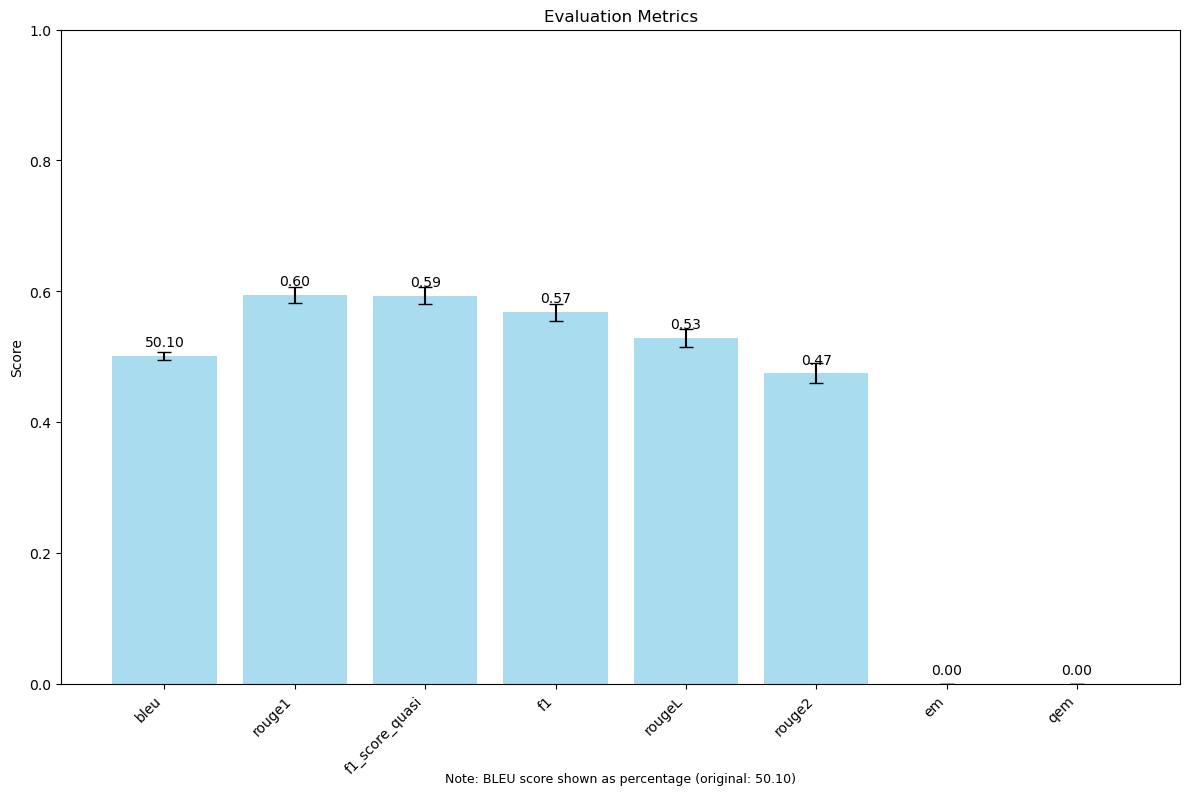

In [82]:
import json

with open(evaluation_results_path, "r") as f:
    data = json.load(f)

fig = plot_metrics(data["results"]["all"])

output_file = os.path.join("./", 'evaluation_metrics.png')
fig.savefig(output_file, bbox_inches='tight')

***

## Model deployment and inference

After training and evaluating our model, we want to make it available for inference. Amazon Bedrock provides a serverless endpoint for model deployment, allowing us to serve the model without managing infrastructure.

The Bedrock Custom Model feature of Amazon Bedrock lets us import our fine-tuned model and access it through the same API as other foundation models. This provides:

In [109]:
import boto3

# Initialize the Bedrock client
bedrock = boto3.client("bedrock", region_name=sess.boto_region_name)

model_path = escrow_model_uri

# Define name for imported model
imported_model_name = "nova-lite2-sagemaker-sft2"

### Creating the Bedrock Custom Model

In [110]:
request_params = {
    "modelName": imported_model_name,
    "modelSourceConfig": {"s3DataSource": {"s3Uri": model_path}},
    "roleArn": role,
    "clientRequestToken": "NovaRecipeSageMaker",
}

# Create the model import job
response = bedrock.create_custom_model(**request_params)

model_arn = response["modelArn"]

# Output the model ARN
print(f"Model import job created with ARN: {model_arn}")

Model import job created with ARN: arn:aws:bedrock:us-east-1:905418197933:custom-model/imported/fa3g6lecz24a


### Monitoring the Model status

After initiating the model import, we need to monitor its progress. The status goes through several states:

* CREATING: Model is being imported
* ACTIVE: Import successful
* FAILED: Import encountered errors

This cell polls the Bedrock API every 60 seconds to check the status of the model import, continuing until it reaches a terminal state (ACTIVE or FAILED). Once the import completes successfully, we'll have the model ARN which we can use for inference.

In [ ]:
from IPython.display import clear_output
import time

# Check CMI job status
while True:
    response = bedrock.list_custom_models(sortBy='CreationTime',sortOrder='Descending')
    model_summaries = response["modelSummaries"]
    status = ""
    for model in model_summaries:
        if model["modelName"] == imported_model_name:
            status = model["modelStatus"].upper()
            model_arn = model["modelArn"]
            print(f'{model["modelStatus"].upper()} {model["modelArn"]} ...')
            if status in ["ACTIVE", "FAILED"]:
                break
    if status in ["ACTIVE", "FAILED"]:
        break
    clear_output(wait=True)
    time.sleep(10)
    
model_arn

CREATING arn:aws:bedrock:us-east-1:905418197933:custom-model/imported/fa3g6lecz24a ...


##### ⚠️ After the model is ACTIVE, create provisioned throughput before running the inference!

Please refer to the official [AWS Documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/prov-thru-purchase.html)

In [ ]:
%%bash 
aws bedrock create-provisioned-model-throughput \
   --model-units 1 \
   --provisioned-model-name custom_PT \
   --model-id <PT_MODEL_ARN>

### Testing the Deployed Model

Now that our model is deployed to Amazon Bedrock, we can invoke it for inference. We'll set up the necessary clients and functions to interact with our model through the Bedrock Runtime API.

Inference Setup Components:
* Bedrock Runtime Client: AWS SDK client for making inference calls
* Helper Function: To handle retry logic and properly format requests
The generate function we're defining:

Applies the proper chat template to user messages
* Handles retry logic for robustness
* Sets appropriate generation parameters like temperature and top-p

This setup allows us to easily test how well our training worked by sending queries to the model and evaluating its responses.

In [ ]:
import boto3
from botocore.config import Config


# Initialize Bedrock Runtime client
session = boto3.Session()
client = session.client(
    service_name="bedrock-runtime",
    region_name=sess.boto_region_name,
    config=Config(
        connect_timeout=300,  # 5 minutes
        read_timeout=300,  # 5 minutes
        retries={"max_attempts": 3},
    ),
)

In [ ]:
def generate(
    model_id,
    messages,
    system_prompt=None,
    tools=None,
    temperature=0.3,
    max_tokens=4096,
    top_p=0.9,
    max_retries=10,
):
    """
    Generate response using the model with proper tokenization and retry mechanism

    Parameters:
        model_id (str): ID of the model to use
        messages (list): List of message dictionaries with 'role' and 'content'
        system_prompt (str, optional): System prompt to guide the model
        tools (dict, optional): Tool configuration for the model
        temperature (float): Controls randomness in generation (0.0-1.0)
        max_tokens (int): Maximum number of tokens to generate
        top_p (float): Nucleus sampling parameter (0.0-1.0)
        max_retries (int): Maximum number of retry attempts

    Returns:
        dict: Model response containing generated text and metadata
    """
    # Prepare base parameters for the API call
    kwargs = {
        "inferenceConfig": {
            "temperature": temperature,
            "maxTokens": max_tokens,
            "topP": top_p,
        },
    }

    # Add optional parameters if provided
    if tools:
        kwargs["toolConfig"] = tools
    if system_prompt:
        kwargs["system"] = [{"text": system_prompt}]

    # Retry logic
    for attempt in range(max_retries):
        try:
            return client.converse(modelId=model_id, messages=messages, **kwargs)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(30)
            else:
                print("Max retries reached. Unable to get response.")
                print(str(e))
                return None

In [ ]:
import json

model_arn = "<PROVISIONED_THROUGHPUT_ARN>"

system_prompt = f"""
You are a helpful AI assistant that can answer questions and provide information.
You can use tools to help you with your tasks.

You have access to the following tools:

<tools>
{{tools}}
</tools>
For each function call, return a json object with function name and parameters:

{{{{\"name\": \"function name\", \"parameters\": \"dictionary of argument name and its value\"}}}}
"""

tools = [
    {
        "toolSpec": {
            "name": "calculate_bmi",
            "description": "Calculate BMI given weight in kg and height in meters",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "weight_kg": {
                            "type": "number",
                            "description": "Property weight_kg",
                        },
                        "height_m": {
                            "type": "number",
                            "description": "Property height_m",
                        },
                    },
                    "required": ["weight_kg", "height_m"],
                },
            },
        }
    },
    {
        "toolSpec": {
            "name": "fetch_weather",
            "description": 'Fetch weather information\n\nArgs:\nquery: The weather query (e.g., "weather in New York")\nnum_results: Number of results to return (default: 1)\n\nReturns:\nJSON string containing weather information',
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "type": "object",
                        "properties": {
                            "query": {
                                "type": "string",
                                "description": "Property query",
                            },
                            "num_results": {
                                "type": "integer",
                                "description": "Property num_results",
                            },
                        },
                        "required": ["query"],
                    },
                },
            },
        }
    },
]

system_prompt = system_prompt.format(tools=json.dumps({"tools": tools}))

messages = [
    {"role": "user", "content": [{"text": "What is the weather in Rome, Italy?"}]},
]

response = generate(
    model_id=model_arn,
    system_prompt=system_prompt,
    messages=messages,
    temperature=0.1,
    top_p=0.9,
)

response["output"]